<a href="https://colab.research.google.com/github/mminn94/Machine-Learning/blob/hayun-dev/%E1%84%89%E1%85%A5%E1%86%BC%E1%84%82%E1%85%B3%E1%86%BC%E1%84%80%E1%85%A2%E1%84%89%E1%85%A5%E1%86%AB4%E1%84%8E%E1%85%A1_%ED%95%98%EC%9C%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 처리 - 나영

In [1]:
#설치 모음
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, models, optimizers
import numpy as np
import random
import math
import pathlib
import os
from pathlib import Path
import shutil
import itertools
import glob
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report, precision_recall_fscore_support)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from matplotlib.ticker import MaxNLocator
from IPython.core import history

In [2]:
root_path = Path('/content')
 #데이터셋 폴더 경로
dataset_path = Path(root_path/'dataset')
print(dataset_path)

/content/dataset


In [3]:
###리셋용 :  필요시 필요 부분만 주석 취소하고 쓰기
def reset():
  # shutil.rmtree("/content/dataset")
  # !rm -rf /content/
  # !rm -rf /content/dataset/
  !rm -rf /content/runs/
  # !rm -rf /content/Capstone_Architectural_Styles_dataset/
  # !rm -rf /content/data/architectural-styles-periods-dataset.zip

  # print("기존 폴더 삭제 완료.")

# reset()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 캐글 api설치 ~ 데이터셋 다운,압축해제,압축파일삭제 ~ 폴더명변경
def InitialSettings():
  !pip install kaggle #kaggle 라이브러리 설치
  !mkdir -p ~/.kaggle #kaggle 폴더 생성
  if os.path.exists('kaggle.json'):
    !cp kaggle.json ~/.kaggle/ #폴더에 kaggle.json 파일 복사
    !chmod 600 ~/.kaggle/kaggle.json #kaggle.json 파일 권한 설정

    if os.path.exists('/root/.kaggle/kaggle.json'):
        !kaggle datasets download -d gustavoachavez/architectural-styles-periods-dataset -p {root_path}  #데이터셋 다운로드
        !unzip -q {root_path}/architectural-styles-periods-dataset.zip -d {root_path}  #데이터셋 압축 해제.

        !rm -rf {root_path}/sample_data #원래 있는 샘플데이터 폴더 삭제
        !rm -rf {root_path}/architectural-styles-periods-dataset.zip #압축zip파일 삭제

        if os.path.exists(f'{root_path}/Capstone_Architectural_Styles_dataset'):
            !mv {root_path}/Capstone_Architectural_Styles_dataset {root_path}/dataset #파일명 dataset으로 변경
            print("--- 데이터셋 준비 완! (dataset 폴더로 이동됨)")
        else:
            print("Capstone_Architectural_Styles_dataset 폴더 없음")
    else:
        print("Kaggle API key file 없음 /root/.kaggle/kaggle.json.")
  else:
      print("kaggle.json 없음. 파일 업로드 했는지 확인.")

# 실행
InitialSettings()

Dataset URL: https://www.kaggle.com/datasets/gustavoachavez/architectural-styles-periods-dataset
License(s): unknown
 99% 1.97G/1.98G [00:20<00:00, 164MB/s]
100% 1.98G/1.98G [00:20<00:00, 104MB/s]
--- 데이터셋 준비 완! (dataset 폴더로 이동됨)


In [5]:
# dataset 하위 디렉터리에서 식민주의 Colonialism 삭제 :
# 1) 이름변경 : Renaissance_and 어쩌구 => Renaissance
# 2) 그 폴더 안에 식민주의 관련 파일 폴더 다 삭제 ('Colonial' or 'Georgian' 포함된 파일명)

def deleteColonialism(dataset_path: Path):
  # Check if the dataset directory exists before proceeding
  if not dataset_path.exists():
      print(f"Dataset 폴더 없음- {dataset_path}.")
      return

  new_class_path = None # 변경된 폴더의 경로 (이름이 'Renaissance'로 바뀐 후의 경로)를 저장할 변수

  for class_path in dataset_path.iterdir():
    # print(class_path.name)
    if 'Renaissance' in class_path.name and class_path.is_dir() :
      if class_path.name != 'Renaissance': # 이름이 변경 전일 경우
        new_class_path = class_path.parent / 'Renaissance' # 변경된 폴더의 경로 (이름이 'Renaissance'로 바뀐 후의 경로)
        !mv {class_path} {new_class_path} #1) 폴더명 변경
        class_path = new_class_path # class_path를 변경된 폴더의 경로로 업데이트
      else : # 이미 이름이 'Renaissance'인 경우, 새 경로 변수를 현재 경로로 설정
        new_class_path = class_path

      for Rene_child_path in class_path.iterdir():
        if (Rene_child_path.is_dir()) and ('Colonial' in Rene_child_path.name )or ('Georgian' in Rene_child_path.name):
          shutil.rmtree(Rene_child_path) #2) 폴더 안에 식민주의 관련 파일 폴더 다 삭제
  # print("--- 현재 폴더 구조 ---")
  # !find {dataset_path}/ -maxdepth 2 -type d -print

deleteColonialism(dataset_path)

In [6]:
# 각 클래스 디렉토리의 하위 폴더 통합
def mergeChildDir():
  for class_path in dataset_path.iterdir(): #클래스 폴더 순회
    # print(class_path)
    for child_path in list(class_path.iterdir()): #하위 폴더 순회. list감싸서 나중에 변경 안 되도록
      if child_path.is_dir():
        # print(child_path)
        for img_file in child_path.iterdir(): #이미지 파일 순회
          destination_path = class_path/img_file.name #파일별 최종 경로 (클래스폴더/이미지파일.jpg)
          # print(destination_path)
          if destination_path.exists():
            print(f"Warning: '{destination_path.name}' 이미 있음.")
            continue
          shutil.move(str(img_file), str(destination_path)) # 파일 이동

        os.rmdir(child_path)

# 실행
mergeChildDir();

In [7]:
# 폴더별 이미지 개수 확인 - 딕셔너리 형태 반환
def countImgsPerClass():
  class_img_counts = {}
  total_count = 0

  for class_dir in dataset_path.iterdir():
    # print(class_dir.name)

    if class_dir.is_dir(): #isdir : '파일'이 아니라 '폴더'가 맞는지 확인
      # print(class_dir.name)
      count = len(list(class_dir.iterdir()))
      # print(count)
      class_img_counts[class_dir.name]=count
      total_count+=count

  # print("총 이미지 개수:",total_count)
  # print("클래스별 이미지 개수:",class_img_counts)
  return class_img_counts

# 실행
countImgsPerClass()

{'Revivalism': 1919,
 'Eclecticism': 1315,
 '21st_Century': 1229,
 'Neoclassicism': 1225,
 'Early_Christian_Medieval': 1338,
 'Renaissance': 521,
 'Modernism': 1860,
 'Classical': 1022,
 'Baroque': 1089}

In [8]:
# 정규화할 때 알 수 없는 파일이 나타남 -> 미리 이상한 파일들 삭제 후 이미지 수 균일하게 줄이기
problematic_files = []
DATA_DIR = str(dataset_path)

# 허용할 유효한 이미지 확장자 목록
valid_extensions = ['.jpeg', '.jpg', '.png', '.bmp', '.gif']

print(f"'{DATA_DIR}'에서 유효하지 않은 확장자나 숨겨진 파일을 찾습니다...")

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        file_path = os.path.join(root, file)

        # 1. 숨겨진 파일(이름이 '.'으로 시작)을 찾기
        if file.startswith('.'):
            print(f"---[숨겨진 파일 발견]---: {file_path}")
            problematic_files.append(file_path)
            continue

        # 2. 확장자가 유효한 목록에 없는 파일을 찾기
        ext = os.path.splitext(file)[1].lower()
        if ext not in valid_extensions:
            print(f"---[유효하지 않은 확장자 발견]---: {file_path}")
            problematic_files.append(file_path)

# 3. 발견된 모든 문제 파일 삭제
if problematic_files:
    print(f"\n총 {len(problematic_files)}개의 문제 파일을 삭제합니다...")
    for file_path in problematic_files:
        os.remove(file_path)
    print("삭제 완료.")
else:
    print("확장자가 이상하거나 숨겨진 파일은 없습니다.")

'/content/dataset'에서 유효하지 않은 확장자나 숨겨진 파일을 찾습니다...
확장자가 이상하거나 숨겨진 파일은 없습니다.


In [9]:
# 1. 데이터셋 최상위 경로 (이전과 동일하게 설정)
DATA_DIR = str(dataset_path)

print(f"'{DATA_DIR}'에서 TensorFlow가 읽을 수 없는 파일을 정밀 검사합니다...")
problematic_files = []

# 2. 모든 파일 경로 수집
all_fnames = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        all_fnames.append(os.path.join(root, file))
print(f"총 {len(all_fnames)}개의 파일을 검사합니다...")

# 3. TensorFlow 함수로 파일 검사
for file_path in all_fnames:
    try:
        # 1. TensorFlow가 파일을 읽는 방식
        img_bytes = tf.io.read_file(file_path)
        # 2. TensorFlow가 이미지를 디코딩하는 방식
        img = tf.io.decode_image(img_bytes)

    except Exception as e:
        # 3. 여기서 오류가 나면 model.fit()에서도 오류 발생
        print(f"---[문제 파일 발견]---: {file_path}")
        print(f"오류: {e}\n")
        problematic_files.append(file_path)

# 4. 발견된 모든 문제 파일 삭제
if problematic_files:
    print(f"\n총 {len(problematic_files)}개의 문제 파일을 삭제합니다...")
    for file_path in problematic_files:
        os.remove(file_path)
    print("삭제 완료.")
else:
    print("TensorFlow 기준으로도 문제가 되는 파일이 없습니다.")

'/content/dataset'에서 TensorFlow가 읽을 수 없는 파일을 정밀 검사합니다...
총 11518개의 파일을 검사합니다...
---[문제 파일 발견]---: /content/dataset/21st_Century/00129.jpg
오류: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 

---[문제 파일 발견]---: /content/dataset/21st_Century/03116.jpg
오류: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 

---[문제 파일 발견]---: /content/dataset/21st_Century/00196.jpg
오류: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 

---[문제 파일 발견]---: /content/dataset/21st_Century/00182.jpg
오류: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of

In [10]:
# 폴더별 이미지 개수 확인 - 딕셔너리 형태 반환
# 500장 이하로 줄어들 수도 있기 때문에 확인 절차
countImgsPerClass()

{'Revivalism': 1919,
 'Eclecticism': 1315,
 '21st_Century': 1224,
 'Neoclassicism': 1225,
 'Early_Christian_Medieval': 1325,
 'Renaissance': 515,
 'Modernism': 1854,
 'Classical': 1010,
 'Baroque': 1083}

In [11]:
# 이미지 수 균일하게 줄이기.
# 나머지는 별도 폴더로 옮기기
def reductionFiles(numPerClass=500):
  class_img_counts = countImgsPerClass()
  min_img_counts=min(class_img_counts.values())
  print("줄이기 전 : ",class_img_counts)

  if min_img_counts<numPerClass:
    print(f"{numPerClass}보다 적은 클래스가 존재합니다.")
    return
  else:
    extraImg_path = dataset_path.parent / 'extra_images' #나머지 이미지들 보관할 경로
    extraImg_path.mkdir(exist_ok=True)
    print(f" 남는 이미지 보관함 생성: {extraImg_path}")

    for class_dir in dataset_path.iterdir():
      class_all_imgs=[f for f in class_dir.iterdir()
                         if f.is_file() and not f.name.startswith('.')]

      class_all_imgs.sort() # 또는 class_all_imgs = sorted(class_all_imgs)
      # random.shuffle(class_all_imgs)
      imgs_to_move = class_all_imgs[numPerClass:] # 옮겨 보관할 파일(500개 초과분)만 선택

      dest_class_dir = extraImg_path / class_dir.name # 옮겨갈 클래스 폴더가 없으면 생성 (예: extra_images/Baroque)
      dest_class_dir.mkdir(exist_ok=True)

      count_moved = 0
      for img_file in imgs_to_move:
        destination = dest_class_dir / img_file.name
        shutil.move(str(img_file), str(destination)) # 삭제(unlink) -> 이동(move)
        count_moved += 1
      if count_moved > 0:
        print(f" -> [{class_dir.name}]클래스 {count_moved}장 보관.")

  print("파일 정리 완료! ")
  return countImgsPerClass()

# 실행
reductionFiles()

줄이기 전 :  {'Revivalism': 1919, 'Eclecticism': 1315, '21st_Century': 1224, 'Neoclassicism': 1225, 'Early_Christian_Medieval': 1325, 'Renaissance': 515, 'Modernism': 1854, 'Classical': 1010, 'Baroque': 1083}
 남는 이미지 보관함 생성: /content/extra_images
 -> [Revivalism]클래스 1419장 보관.
 -> [Eclecticism]클래스 815장 보관.
 -> [21st_Century]클래스 724장 보관.
 -> [Neoclassicism]클래스 725장 보관.
 -> [Early_Christian_Medieval]클래스 825장 보관.
 -> [Renaissance]클래스 15장 보관.
 -> [Modernism]클래스 1354장 보관.
 -> [Classical]클래스 510장 보관.
 -> [Baroque]클래스 583장 보관.
파일 정리 완료! 


{'Revivalism': 500,
 'Eclecticism': 500,
 '21st_Century': 500,
 'Neoclassicism': 500,
 'Early_Christian_Medieval': 500,
 'Renaissance': 500,
 'Modernism': 500,
 'Classical': 500,
 'Baroque': 500}

In [12]:
# 1. 기본 설정
DATA_DIR = pathlib.Path(str(dataset_path))
IMG_SIZE_INT = 128
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
TOTAL_EPCOHS = 50
print("데이터셋 수동 파이프라인 구축 시작...")

# 2. 파일 리스트 및 클래스 정의
all_image_paths = list(DATA_DIR.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# 클래스 이름 추출 및 정렬
class_names = sorted([item.name for item in DATA_DIR.glob('*') if item.is_dir()])
num_classes = len(class_names)

print(f"--- 총 이미지 개수: {len(all_image_paths)} ---")
print(f"--- 클래스 목록 ({num_classes}개): {class_names} ---")

# 랜덤 셔플
random.seed(SEED)
random.shuffle(all_image_paths)

# Train / Validation 분리
val_count = int(len(all_image_paths) * 0.2)
train_paths = all_image_paths[val_count:]
val_paths = all_image_paths[:val_count]

print(f"--- 훈련 데이터: {len(train_paths)}장 / 검증 데이터: {len(val_paths)}장 ---")

# 3. 데이터 로드 함수
# 클래스 이름들을 미리 Tensor 상수로 변환해둡니다. (함수 내부에서 쓰기 위함)
class_names_tensor = tf.constant(class_names)

def load_image_and_label(path):
    # 1) 이미지 읽기
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3]) # 모양 힌트 제공

    # 2) 라벨 추출
    parts = tf.strings.split(path, os.path.sep)
    label_name = parts[-2]

    # 3) [수정된 부분] for문 제거 -> TensorFlow 비교 연산 사용
    # 전체 클래스 이름 리스트와 현재 라벨 이름을 한 번에 비교합니다.
    # 예: label_name='Baroque', class_names=['21st', 'Baroque', ...]
    # comparison -> [False, True, False, ...]
    comparison = tf.equal(class_names_tensor, label_name)

    # True가 있는 위치(인덱스)를 찾습니다.
    label_index = tf.argmax(comparison)

    # 원-핫 인코딩
    label = tf.one_hot(label_index, depth=num_classes)

    return image, label

# tf.data.Dataset 생성
train_ds_raw = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds_raw = train_ds_raw.map(load_image_and_label, num_parallel_calls=AUTOTUNE)

val_ds_raw = tf.data.Dataset.from_tensor_slices(val_paths)
val_ds_raw = val_ds_raw.map(load_image_and_label, num_parallel_calls=AUTOTUNE)

# 4. 전처리 함수
def preprocess_squash(image, label):
    image = tf.image.resize(image, (IMG_SIZE_INT, IMG_SIZE_INT))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 5. 파이프라인 분기 (데이터셋 2세트 생성)
train_ds_A0 = train_ds_raw.map(preprocess_squash, num_parallel_calls=AUTOTUNE)
val_ds_A0   = val_ds_raw.map(preprocess_squash, num_parallel_calls=AUTOTUNE)

train_ds_A0 = train_ds_A0.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds_A0   = val_ds_A0.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

print("모든 데이터셋 준비 완료!")

데이터셋 수동 파이프라인 구축 시작...
--- 총 이미지 개수: 4500 ---
--- 클래스 목록 (9개): ['21st_Century', 'Baroque', 'Classical', 'Early_Christian_Medieval', 'Eclecticism', 'Modernism', 'Neoclassicism', 'Renaissance', 'Revivalism'] ---
--- 훈련 데이터: 3600장 / 검증 데이터: 900장 ---
모든 데이터셋 준비 완료!


In [13]:
# 1119나영 - a1증강버전에서 앞의 수동파이프라인 써서 이건 일단 전체 주석처리했습니다.
DATA_DIR = str(dataset_path) #/content/data/Merged_dataset
# print(DATA_DIR)
# 이미지 사이즈/배치/seed
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42 #데이터를 나눌 때 사용할 랜덤 시드
AUTOTUNE = tf.data.AUTOTUNE #tf.data 파이프라인의 성능을 자동으로 최적화

#데이터셋 파이프라인 구축 (Train/Val 분리)
# def createTrainValDatasets():
train_ds_A0 = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,             # 6개 클래스 폴더가 들어있는 상위 폴더
    labels="inferred",    # 폴더명을 라벨로 사용
    label_mode="categorical",      # 원-핫 인코딩 (다중 클래스 분류용)
    validation_split=0.2, # 전체 데이터 중 20%를 검증용으로 validation
    subset="training",    # "나머지 80% -> 훈련용 데이터 training
    seed=SEED,
    image_size=IMG_SIZE,  # 모든 이미지를 자동 리사이징
    batch_size=BATCH_SIZE
)
val_ds_A0 = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",    # 폴더명을 라벨로 사용
    label_mode="categorical",      # 원-핫 인코딩 (다중 클래스 분류용)
    validation_split=0.2, # 전체 데이터 중 20%를 검증용으로 validation
    subset="validation",    # "나머지 80% -> 훈련용 데이터 training
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Keras가 폴더명을 기반으로 자동 생성한 클래스 이름들을 확인.
class_names = train_ds_A0.class_names
print("\n--- 클래스 이름 (자동 생성된 라벨 순서) ---")
print(class_names)
# 파이프라인 최적화(캐시/프리패치)
train_dataset = train_ds_A0.cache().prefetch(AUTOTUNE)
val_dataset   = val_ds_A0.cache().prefetch(AUTOTUNE)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.
Found 4500 files belonging to 9 classes.
Using 900 files for validation.

--- 클래스 이름 (자동 생성된 라벨 순서) ---
['21st_Century', 'Baroque', 'Classical', 'Early_Christian_Medieval', 'Eclecticism', 'Modernism', 'Neoclassicism', 'Renaissance', 'Revivalism']


In [14]:
# 정규화·증강 레이어 파이프라인에 적용
# def realReadyDataSets():
# train_dataset, val_dataset, class_names=createTrainValDatasets()
# 데이터 증강(Augmentation)
# [수정사항 - 채민] 0~255 픽셀을 -1~+1 범위로 정규화 (MobileNetV2 전용 함수)
# rescale = layers.Rescaling(1./255)
#데이터 증강(Augmentation) 레이어 정의 (학습 데이터에만 적용)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data_augmentation = keras.Sequential(   # 'Sequential' 모델을 사용해 증강 기법들을 파이프라인처럼 만든다.
    [                                   # 훈련 중에 실시간으로 이미지를 변형
        layers.RandomFlip("horizontal"),   # 좌우 뒤집기
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),            # 10% 줌 인/아웃
        layers.RandomContrast(0.1),        # 대비 변화
    ],
    name="data_augmentation"# 이름 붙이기
)
## training학습용 : 증강(data_augmentation) -> MobileNetV2 정규화만 적용
train_dataset_ready = (
    train_dataset
    .map(lambda x, y: (preprocess_input(data_augmentation(x)),y), num_parallel_calls=AUTOTUNE) #x:원본이미지, y:원본레이블
    .prefetch(AUTOTUNE)
)

# 검증용 :MobileNetV2 정규화만!
val_dataset_ready = (
    val_dataset
    .map( lambda x, y: (preprocess_input(x),y), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
print("[OK] 파이프라인 (MobileNetV2 정규화 적용) 준비 완료.")
# return train_dataset_ready, val_dataset_ready, class_names

# 한 배치 꺼내서 모양 확인
print("한 배치 꺼내서 모양 확인")
xb, yb = next(iter(train_dataset_ready))
print("이미지 배치:", xb.shape, xb.dtype)
# 이미지 배치:            예 : (32, 224, 224, 3) <dtype: 'float32'>
# 이미지 배치 (입력 데이터): (배치 크기, 세로px, 가로px, 채널수:rgb) <dtype: 'float32'>
# 의미 : 32장의 224×224 RGB 컬러 이미지

print("라벨 배치 :", yb.shape, yb.dtype)
# 라벨 배치 :            (32, 6) <dtype: 'float32'>
# 라벨 배치 (정답 데이터) : (배치크기, 클래스 수) <dtype: 'float32'>
# 의미 : 9개 클래스 중 해당되는 위치가 1인 one-hot 벡터 ex[0., 0., 0., 0., 1., 0.]

print("정규화 후 최소값: ", tf.reduce_min(xb).numpy())
print("정규화 후 최대값: ", tf.reduce_max(xb).numpy())

[OK] 파이프라인 (MobileNetV2 정규화 적용) 준비 완료.
한 배치 꺼내서 모양 확인
이미지 배치: (32, 128, 128, 3) <dtype: 'float32'>
라벨 배치 : (32, 9) <dtype: 'float32'>
정규화 후 최소값:  -1.0
정규화 후 최대값:  1.0


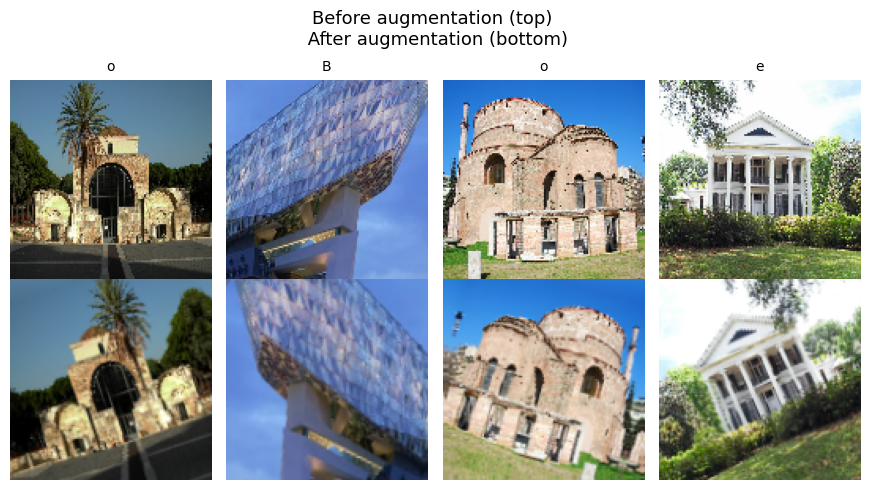

In [15]:
def show_augment_comparison(train_dataset,
                            data_augmentation,
                            class_names=None,
                            max_images=8):
    """
    train_dataset에서 배치 1개를 꺼내 '증강 전/후' 이미지를 8장 비교로 보여줍니다.
    - 위 줄: 증강 전(원본 배치에서 꺼낸 이미지)
    - 아래 줄: 같은 이미지에 data_augmentation을 적용한 결과
    """
    # 배치 하나 추출
    images, labels = next(iter(train_dataset))
    n = min(max_images, images.shape[0])
    images = images[:n]  # (n, H, W, 3)

    # labels가 one-hot이면 argmax로 인덱스 변환
    try:
        label_idx = tf.argmax(labels[:n], axis=1).numpy()
    except Exception:
        # sparse일 수도 있으니 대비
        label_idx = labels[:n].numpy().astype(int).reshape(-1)

    # ----- 증강 적용 (training=True를 명시해서 랜덤 변환 강제) -----
    # 주의: data_augmentation은 정규화 전/후 모두 동작하지만,
    # 보통은 정규화 전 uint8/float32 범위(0~255) 이미지에 적용해도 무방합니다.
    aug_images = data_augmentation(images, training=True)

    # ----- 시각화용 유틸: 값을 0~255로 맞춘 뒤 uint8로 캐스팅 -----
    def to_uint8(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        # 만약 0~1 범위라면 255 스케일, 0~255면 그대로 클리핑만
        mx = tf.reduce_max(x)
        x = tf.where(mx <= 1.0, x * 255.0, x)
        x = tf.clip_by_value(x, 0.0, 255.0)
        return tf.cast(x, tf.uint8).numpy()

    vis_orig = to_uint8(images)
    vis_aug  = to_uint8(aug_images)

    # ----- 플로팅 -----
    plt.figure(figsize=(2.2*n, 5))
    # 윗줄: 원본
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(vis_orig[i])
        title = None
        if class_names is not None:
            title = class_names[label_idx[i]]
        if title:
            plt.title(title, fontsize=10)
        plt.axis("off")
    # 아랫줄: 증강 후
    for i in range(n):
        plt.subplot(2, n, n + i + 1)
        plt.imshow(vis_aug[i])
        plt.axis("off")
    plt.suptitle("Before augmentation (top) \n After augmentation (bottom)", fontsize=13)
    plt.tight_layout()
    plt.show()
show_augment_comparison(train_dataset,data_augmentation,'Baroque_Rococo',4 )

# A1 (정사각형 + 증강)


In [16]:
#  A1용 데이터 증강  (정사각형 + 증강)
data_augmentation_A1 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ],
    name="aug_A1_square_plus_aug"
)

def preprocess_squash_with_aug(image, label):
    image = tf.image.resize(image, (IMG_SIZE_INT, IMG_SIZE_INT))
    image = tf.cast(image, tf.float32)

    image = data_augmentation_A1(image, training=True)

    return image, label

# A1용 (정사각형 + 증강)
# train: 정사각형 + 증강
train_ds_A1 = train_ds_raw.map(
    preprocess_squash_with_aug,
    num_parallel_calls=AUTOTUNE
)
train_ds_A1 = train_ds_A1.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# val: 정사각형만 (A0와 동일, 증강 X)
val_ds_A1 = val_ds_raw.map(
    preprocess_squash,
    num_parallel_calls=AUTOTUNE
)
val_ds_A1 = val_ds_A1.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

print("A0 / A1 데이터셋 준비 완료!")

A0 / A1 데이터셋 준비 완료!


# MobileNetV2 최종 H256, D0.5

In [17]:
# 1. 실험 준비
INPUT_SHAPE = (128, 128, 3)
NUM_CLASSES = 9

# 실험용 모델 생성 함수 (헤드 구조/Dropout 실험용)
def build_model_head(head_units=128, dropout_rate=0.5, lr=0.001, optimizer_name = "adam"):   # 입력 없을 때의 디폴트 값
    # 백본 MobileNetV2 다시 불러오기 (동일한 설정)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # 앞부분과 동일하게 동결

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(head_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)   # 입력 -> 출력 연결한 모델 완성

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [18]:
# 4. 최종 모델 결정 및 학습 (H256 and D0.5)
def run_final_training(train_ds, val_ds, mode_name="final_head"):
    """
    train_ds: 학습 데이터셋 (A0)
    val_ds  : 검증 데이터셋
    mode_name: 파일 저장명 (기본값: final_head)
    """

    # 1) 설정값 정의 (최종 결정된 값 H256, D0.5, LR 0.001)
    HEAD_UNITS = 256
    DROPOUT_RATE = 0.5
    LEARNING_RATE = 0.001
    EPOCHS = 50

    print(f"=== [{mode_name}] 최종 학습 시작 ===")
    print(f"설정: Units={HEAD_UNITS}, Drop={DROPOUT_RATE}, LR={LEARNING_RATE}")

    # 2) 폴더 생성
    os.makedirs("runs", exist_ok=True)

    # 3) 모델 생성
    model = build_model_head(HEAD_UNITS, DROPOUT_RATE, LEARNING_RATE)

    # 4) 콜백 설정 (파일 이름이 mode_name에 따라 결정됨)
    # 예: runs/best_head_final_A0.keras
    ckpt_path = f"runs/best_head_{mode_name}.keras"
    log_path = f"runs/train_log_{mode_name}.csv"

    cbs = [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', save_best_only=True),
        callbacks.CSVLogger(log_path)
    ]

    # 5) 학습 시작
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cbs,
        verbose=1
    )

    print(f"--- [{mode_name}] 학습 완료! 저장경로: {ckpt_path} ---")
    return model, history

모델 이름

최종 모델 = best_head_final_head.keras

**증강 처리 X (A0) = best_head_A0_Squash** = 기본 비교 모델

증강 처리 모델(A1) = best_head_A1_Squash_Aug

옵티마이저 변화 (B1) = best_head_B1_AdamW

동결 해제 (C1) = best_head_C1_FineTuned


# A0, A1 데이터 증강 - 하윤


In [19]:
#  A0 vs A1
# A0: 정사각형(Squash) 데이터로 학습
model_A0, history_A0 = run_final_training(train_ds_A0, val_ds_A0, "A0_Squash")

=== [A0_Squash] 최종 학습 시작 ===
설정: Units=256, Drop=0.5, LR=0.001
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 383ms/step - accuracy: 0.2159 - loss: 2.3253 - val_accuracy: 0.3267 - val_loss: 1.8843
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.3238 - loss: 1.8658 - val_accuracy: 0.3833 - val_loss: 1.7529
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.3697 - loss: 1.7434 - val_accuracy: 0.3578 - val_loss: 1.7369
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.3969 - loss: 1.6859 - val_accuracy: 0.3967 - val_loss: 1.6753
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.4072 - loss: 1.6441 - val_accuracy: 0.3989 - val_loss: 1.6413
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.4253 - loss: 1.5931 - val_accuracy: 0.4067 - val_loss: 1.6535
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.4419 - loss: 1.5624 - val_accurac

In [20]:
# A1: 정사각형 + 증강 데이터로 학습
model_A1, history_A1 = run_final_training(train_ds_A1, val_ds_A1, "A1_Squash_Aug")

print("최종 모델 (A0: Squash / A1: Squash+Aug) 2개 학습 완료!")

=== [A1_Squash_Aug] 최종 학습 시작 ===
설정: Units=256, Drop=0.5, LR=0.001
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 419ms/step - accuracy: 0.1729 - loss: 2.3775 - val_accuracy: 0.1400 - val_loss: 2.5534
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2713 - loss: 1.9716 - val_accuracy: 0.1400 - val_loss: 2.7611
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2862 - loss: 1.9200 - val_accuracy: 0.1289 - val_loss: 2.8864
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3010 - loss: 1.8954 - val_accuracy: 0.1267 - val_loss: 3.0956
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3150 - loss: 1.8479 - val_accuracy: 0.1478 - val_loss: 3.1212
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3183 - loss: 1.8340 - val_accuracy: 0.1333 - val_loss: 3.3599
--- [A1_Squash_Aug] 학습 완료! 저장경로: runs/best_head_A1_Squash_Aug.keras ---
최종 모델 (A0: Squash / A1: Squash+Aug) 2개 학습 완료!


# B0, B1 Optimizer 변경 (Adam vs AdamW) - 채정

In [21]:
# 1. B0 / B1 옵티마이저 설정에 따라 학습을 수행하는 함수 정의
def train_with_optimizer_config(train_ds, val_ds, epochs=50, mode_name="B1_AdamW"):
    # 모델 생성 (아까 통합한 build_model_head 호출!)
    model = build_model_head(
        head_units=256,
        dropout_rate=0.5,
        lr=0.001,
        optimizer_name="adamw"
    )

    # 콜백 기본 세팅 (EarlyStopping + ModelCheckpoint + CSVLogger)
    os.makedirs("runs", exist_ok=True)

    ckpt_path = f"runs/best_head_{mode_name}.keras"
    log_path = f"runs/train_log_{mode_name}.csv"

    cb_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', save_best_only=True),
        callbacks.CSVLogger(log_path)
    ]

    # ReduceLROnPlateau 스케줄러 추가
    lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
    cb_list.append(lr_scheduler)

    print(f"=== [{mode_name}] 학습 시작 (Optimizer: AdamW) ===")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=cb_list,
        verbose=1
    )

    best_val = max(history.history["val_accuracy"])
    print(f"최고 정확도: {best_val:.4f}")

    return model, history, best_val

In [22]:
# 11/19 나영 B0/ B1 Optimizer 변경 가능 버전
# 11/19 나영 변경1  :옵티마이저 이름 선택 가능하도록 파라미터 수정한 버전입니다! -기본값: adamw
def train_with_optimizer_ver2(train_ds, val_ds, epochs=50, mode_name="B1_AdamW", opti_name='adamw'):
    # 모델 생성
    model = build_model_head(
        head_units=256,
        dropout_rate=0.5,
        lr=0.001,
        optimizer_name=opti_name # 'adam' or 'adamw'
    )

    # 콜백 기본 세팅 (EarlyStopping + ModelCheckpoint + CSVLogger)
    os.makedirs("runs", exist_ok=True)
    ckpt_path = f"runs/best_head_{mode_name}.keras"
    log_path = f"runs/train_log_{mode_name}.csv"

    cb_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', save_best_only=True),
        callbacks.CSVLogger(log_path)
    ]

    # 11/19 나영 변경2 : adam이면 스케줄러 추가 안 함!
    if opti_name == 'adamw':
      # ReduceLROnPlateau 스케줄러 추가
      lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
      cb_list.append(lr_scheduler)

    print(f"=== [{mode_name}] 학습 시작 (Optimizer: {opti_name}) ===")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=cb_list,
        verbose=1
    )

    best_val = max(history.history["val_accuracy"])
    print(f"최고 정확도: {best_val:.4f}")
    #11/19 나영 변경3 : ckpt_path도 반환함.
    return model, history, best_val ,ckpt_path

In [23]:
# 옵티마이저 설정에 따른 단독 실험 불필요 → 이후 내용 전부 주석 처리
exp_opt_histories = {}  # 그래프 그릴 데이터를 모을 딕셔너리
exp_opt_results = {}    # 최고 점수를 모을 딕셔너리

# [B0 기준 모델] A0의 결과를 그대로 사용
history_B0 = history_A0
acc_B0 = max(history_B0.history["val_accuracy"])

exp_opt_histories["B0"] = history_B0.history
exp_opt_results["B0"] = acc_B0

# [B1 실험] AdamW + Scheduler
model_B1, history_B1, acc_B1 = train_with_optimizer_config(train_ds=train_ds_A0,
                                                           val_ds = val_ds_A0,
                                                           mode_name ="B1_AdamW")
exp_opt_histories["B1_AdamW"] = history_B1.history
exp_opt_results["B1_AdamW"] = acc_B1

print("최종 모델 (B0: Adam / B1: AdamW + Scheduler) 2개 학습 완료!")

=== [B1_AdamW] 학습 시작 (Optimizer: AdamW) ===
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 255ms/step - accuracy: 0.2082 - loss: 2.3011 - val_accuracy: 0.3244 - val_loss: 1.8656 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.3154 - loss: 1.8489 - val_accuracy: 0.3633 - val_loss: 1.7572 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.3811 - loss: 1.7285 - val_accuracy: 0.3889 - val_loss: 1.7241 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.3999 - loss: 1.6645 - val_accuracy: 0.4233 - val_loss: 1.6758 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.4052 - loss: 1.6368 - val_accuracy: 0.4144 - val_loss: 1.6599 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.4436 - loss: 1.5742 - val_accuracy: 0.4033 - val_loss: 1.6656 - learning_rate: 0.0010
Epoch 7/50
113/113 ━━━━━━━

# C0, C1 파인튜닝 성능 개선 - 채민

In [27]:
# 마지막으로 실행된 epoch 몇인지 계산

# run_final_training 함수가 남긴 파일 이름
log_file_name = "train_log_A0_Squash.csv"
log_file_path = f"runs/{log_file_name}"

# last_epoch 계산
if os.path.exists(log_file_path):
    df = pd.read_csv(log_file_path)
    last_epoch = len(df)
    print(f"✅ 로그 분석 완료: Step B는 {last_epoch} 에포크에서 종료되었습니다.")
else:
    # 로그 파일이 없다면, 최대 에포크인 50으로 가정하고 경고 메시지 출력
    last_epoch = 50
    print(f" 로그 파일 ({log_file_path})을 찾을 수 없습니다.")
    print(f"last_epoch을 최대값인 {last_epoch}으로 설정합니다. 정확한 값 확인이 필요합니다.")



✅ 로그 분석 완료: Step B는 22 에포크에서 종료되었습니다.


In [28]:
print("--- C1 파인튜닝 실험 시작 ---")

def run_fine_tuning(base_model_path, train_ds, val_ds,
                    mode_name="C1_FineTuned",
                    unfreeze_count=3,
                    base_lr=1e-5,
                    initial_epoch=50,
                    add_epochs=50):
    """
    base_model_path: C0(A0) 모델이 저장된 경로 (예: runs/best_head_A0_Squash_Final.keras)
    train_ds, val_ds: 데이터셋
    mode_name: 저장될 파일 이름 태그
    unfreeze_count: 뒤에서부터 몇 개의 레이어를 풀 것인지 (기본 10)
    base_lr: 파인튜닝 학습률 (아주 낮게 설정, 기본 1e-5)
    initial_epoch: C0가 끝난 시점 (그래프 이어그리기용, 기본 20)
    add_epochs: 추가로 더 학습할 횟수 (기본 10)
    """
    print(f"[C1 파인튜닝 시작] 모드: {mode_name}")
    print(f"로드 경로: {base_model_path}")

    # 1. C0 모델 로드
    if not os.path.exists(base_model_path):
        raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {base_model_path}")

    model = models.load_model(base_model_path)

    # 2. 베이스 모델(MobileNetV2) 접근
    # model_C1.layers[1]이 MobileNetV2 백본임을 직접 지정하여 안정성 확보
    base_model = model.layers[1]

    # 전체 동결 해제 후 -> 앞부분 다시 동결
    base_model.trainable = True

    # 전체 레이어 수 - 10개 지점 계산
    fine_tune_at = len(base_model.layers) - unfreeze_count

    # 앞부분 다시 얼리기
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"--> 전체 레이어 {len(base_model.layers)}개 중 뒤쪽 {unfreeze_count}개만 학습합니다.")

    # 3. 컴파일 (낮은 학습률)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=base_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 4. 콜백 설정
    os.makedirs("runs", exist_ok=True)
    ckpt_path = f"runs/best_model_{mode_name}.keras"
    log_path = f"runs/train_log_{mode_name}.csv"

    cbs_C1 = [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', save_best_only=True),
        callbacks.CSVLogger(log_path)
    ]

    # 5. 학습 시작
    total_epochs = initial_epoch + add_epochs

    history_C1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=total_epochs,
        initial_epoch=initial_epoch, # 20부터 시작한다고 명시 (그래프 X축 연결됨)
        callbacks=cbs_C1,
        verbose=1
    )

    print(f"--- [{mode_name}] 파인튜닝 완료! 저장경로: {ckpt_path} ---")
    return model, history_C1

--- C1 파인튜닝 실험 시작 ---


In [29]:
## 에포크 이어지도록

# 1. 불러올 C0 모델 경로 지정
load_path = "runs/best_head_A0_Squash.keras"

# 2. C1 파인튜닝 실행
# train_ds_A0와 val_ds_A0를 그대로 사용합니다.
model_C1, history_C1 = run_fine_tuning(
    base_model_path=load_path,
    train_ds=train_ds_A0,
    val_ds=val_ds_A0,
    mode_name="C1_FineTuned_Squash",  # 파일명 태그
    unfreeze_count=3,                # 3개만 풀기
    base_lr=1e-5,                    # 학습률 0.00001
    initial_epoch=last_epoch,        # <--- 이 부분이 수정되었습니다! (자동 이어하기)
    add_epochs=50                    # 50 epoch 추가 (총 last_epoch + 50까지)
)

[C1 파인튜닝 시작] 모드: C1_FineTuned_Squash
로드 경로: runs/best_head_A0_Squash.keras
--> 전체 레이어 154개 중 뒤쪽 3개만 학습합니다.
Epoch 23/72
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 0.2856 - loss: 6.3961 - val_accuracy: 0.4156 - val_loss: 1.7791
Epoch 24/72
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.3481 - loss: 4.5534 - val_accuracy: 0.3811 - val_loss: 1.9755
Epoch 25/72
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.4042 - loss: 3.5607 - val_accuracy: 0.3667 - val_loss: 2.0755
Epoch 26/72
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - accuracy: 0.4155 - loss: 3.1137 - val_accuracy: 0.3556 - val_loss: 2.1329
Epoch 27/72
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 203ms/step - accuracy: 0.4427 - loss: 2.7303 - val_accuracy: 0.3400 - val_loss: 2.1500
Epoch 28/72
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.4479 - loss: 2.5199 - val_accuracy: 0.3300 - val_loss: 2.1573
--- [C1_FineTuned_Squash] 파인튜닝 완료! 저장경로: runs/best_model_C1_FineTuned_Squash.keras ---


In [30]:
# C0의 최고 val_accuracy
c0_best_acc = max(history_A0.history['val_accuracy'])
c1_best_acc = max(history_C1.history['val_accuracy'])

print(f"C0 (동결) 최고 정확도: {c0_best_acc:.4f}")
print(f"C1 (파인튜닝 - 에포크 증가) 최고 정확도: {c1_best_acc:.4f}")

if c1_best_acc > c0_best_acc:
    print(f"--> 성능 개선 확인: {c1_best_acc - c0_best_acc:.4f} 만큼 향상됨!")
else:
    print("--> 성능 개선 없음. (학습률, 동결 레이어 수 등 재검토 필요)")

C0 (동결) 최고 정확도: 0.4656
C1 (파인튜닝 - 에포크 증가) 최고 정확도: 0.4156
--> 성능 개선 없음. (학습률, 동결 레이어 수 등 재검토 필요)


In [31]:
### 에포크 이어지게 수정된 부분

def train_combination(A=0, B=0, C=0):
  mode_name = f"TrainCombi_A{A}_B{B}_C{C}"
  print(f"== 시작!!! mode_name : {mode_name}")


  train_ds, val_ds = None, None

  if A == 0 :
    train_ds, val_ds = train_ds_A0, val_ds_A0
  elif A == 1 :
    train_ds, val_ds = train_ds_A1, val_ds_A1
  else:
    return None, None

  opti_name = 'adam' if B == 0 else 'adamw'


  model_stepB, history_stepB, acc_stepB, ckptPath_stepB = train_with_optimizer_ver2(
      train_ds=train_ds,
      val_ds=val_ds,
      epochs=50,
      mode_name=f"{mode_name}_StepB",
      opti_name=opti_name
  )

  final_history = None
  final_acc = 0


  last_epoch = len(history_stepB.history['val_loss'])
  print(f"--> Step B는 {last_epoch} 에포크에서 종료되었습니다.")

  if C == 0 :
    final_history = history_stepB.history
    final_acc = acc_stepB
    print(f"==종료!! C=0 파인튜닝 없이 종료함")

  elif C == 1 :

    print(f"--> 파인튜닝을 {last_epoch}부터 시작하여 50 에포크를 추가합니다.")

    model_stepC, history_stepC = run_fine_tuning(
        base_model_path= ckptPath_stepB,
        train_ds= train_ds,
        val_ds= val_ds,
        mode_name= f"{mode_name}_StepC",
        initial_epoch=last_epoch,      # <--- 여기서부터 이어하기
        add_epochs=50                  # <--- 50번 더 하기
    )

    final_history = history_stepC.history
    final_acc = max(history_stepC.history["val_accuracy"])
    print(f"==종료!! C=1 파인튜닝까지 완")

  return final_history, final_acc

In [32]:
# 진행할 조합
combi_list=[
    [1,0,0], # A1 B0 C0
    [0,0,0], # A0 B0 C0
    [0,1,0], # A0 B1 C0
    [0,0,1], # A0 B0 C1
    [1,1,0], # A1 B1 C0
    [1,0,1], # A1 B0 C1
    [0,1,1], # A0 B1 C1
    [1,1,1]  # A1 B1 C1
]

# 결과 모을 곳
final_histories = {}
final_results = {}

# 반복문으로 자동 실험 시작
for combi in combi_list:
    # 리스트에서 A, B, C 값 꺼내기
    a, b, c = combi

    # 함수 실행!
    hist, acc = train_combination(A=a, B=b, C=c)

    # 결과 저장 (None이 아닐 경우만)
    if hist is not None:
        name = f"A{a}_B{b}_C{c}"
        final_histories[name] = hist
        final_results[name] = acc

print("\n ***** 모든 실험 루프 완료! *****")

== 시작!!! mode_name : TrainCombi_A1_B0_C0
=== [TrainCombi_A1_B0_C0_StepB] 학습 시작 (Optimizer: adam) ===
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.1783 - loss: 2.3644 - val_accuracy: 0.1522 - val_loss: 2.6389
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2442 - loss: 1.9991 - val_accuracy: 0.1744 - val_loss: 2.7930
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2909 - loss: 1.9352 - val_accuracy: 0.1533 - val_loss: 3.1471
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2772 - loss: 1.9129 - val_accuracy: 0.1611 - val_loss: 3.2994
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3128 - loss: 1.8574 - val_accuracy: 0.1600 - val_loss: 3.2186
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3298 - loss: 1.8225 - val_accuracy: 0.1667 - val_loss: 3.4655
최고 정확도: 0.1744
--> Step B는 6 에포크에서 종료되었습니다.
==종료!! C=0 파인튜닝 없이 종료함
== 시작!!! mode_name : TrainCombi_A0_B0_C0
=== [TrainCombi

In [33]:
## 파인튜닝 적용 전/후 에포크 데이터 이어붙이는 코드
## 이 코드를 적용 안 하면, 그래프는 파인튜닝 적용 후의 결과만 나옴

final_histories = {}
final_results = {}

print("저장된 CSV 로그 파일 읽어오는 중...")

for A, B, C in combi_list:
    mode_name = f"TrainCombi_A{A}_B{B}_C{C}"

    # 1. Step B (1단계) 로그 파일 찾기
    path_B = f"runs/train_log_{mode_name}_StepB.csv"

    if not os.path.exists(path_B):
        print(f"파일 없음: {path_B} (실험이 제대로 안 끝났을 수 있음)")
        continue

    # CSV 읽기 (pandas 데이터프레임)
    df_B = pd.read_csv(path_B)

    # 2. Step C (2단계 - 파인튜닝) 처리
    if C == 1:
        path_C = f"runs/train_log_{mode_name}_StepC.csv"
        if os.path.exists(path_C):
            df_C = pd.read_csv(path_C)

            # [핵심] 두 데이터프레임(표) 이어 붙이기
            # ignore_index=True: 인덱스(0,1,2...)를 0부터 다시 예쁘게 정렬
            df_final = pd.concat([df_B, df_C], ignore_index=True)

            print(f" - [{mode_name}] Step B({len(df_B)}) + Step C({len(df_C)}) 병합 완료!")
        else:
            print(f"Step C 파일 없음: {path_C}")
            df_final = df_B # 없으면 그냥 B만 씀
    else:
        # C=0이면 B가 최종
        df_final = df_B
        print(f" - [{mode_name}] Step B 단독 로드 완료.")

    # 3. 딕셔너리에 저장 (그래프 그리기용)
    # 데이터프레임을 딕셔너리 형태로 변환해서 저장
    final_histories[f"A{A}_B{B}_C{C}"] = df_final.to_dict(orient='list')

    # 최종 정확도 저장
    final_results[f"A{A}_B{B}_C{C}"] = df_final['val_accuracy'].max()

print("데이터 이어붙이기 완료")

저장된 CSV 로그 파일 읽어오는 중...
 - [TrainCombi_A1_B0_C0] Step B 단독 로드 완료.
 - [TrainCombi_A0_B0_C0] Step B 단독 로드 완료.
 - [TrainCombi_A0_B1_C0] Step B 단독 로드 완료.
 - [TrainCombi_A0_B0_C1] Step B(18) + Step C(6) 병합 완료!
 - [TrainCombi_A1_B1_C0] Step B 단독 로드 완료.
 - [TrainCombi_A1_B0_C1] Step B(7) + Step C(6) 병합 완료!
 - [TrainCombi_A0_B1_C1] Step B(24) + Step C(6) 병합 완료!
 - [TrainCombi_A1_B1_C1] Step B(6) + Step C(7) 병합 완료!
데이터 이어붙이기 완료


final_histories, final_results 모두 있음


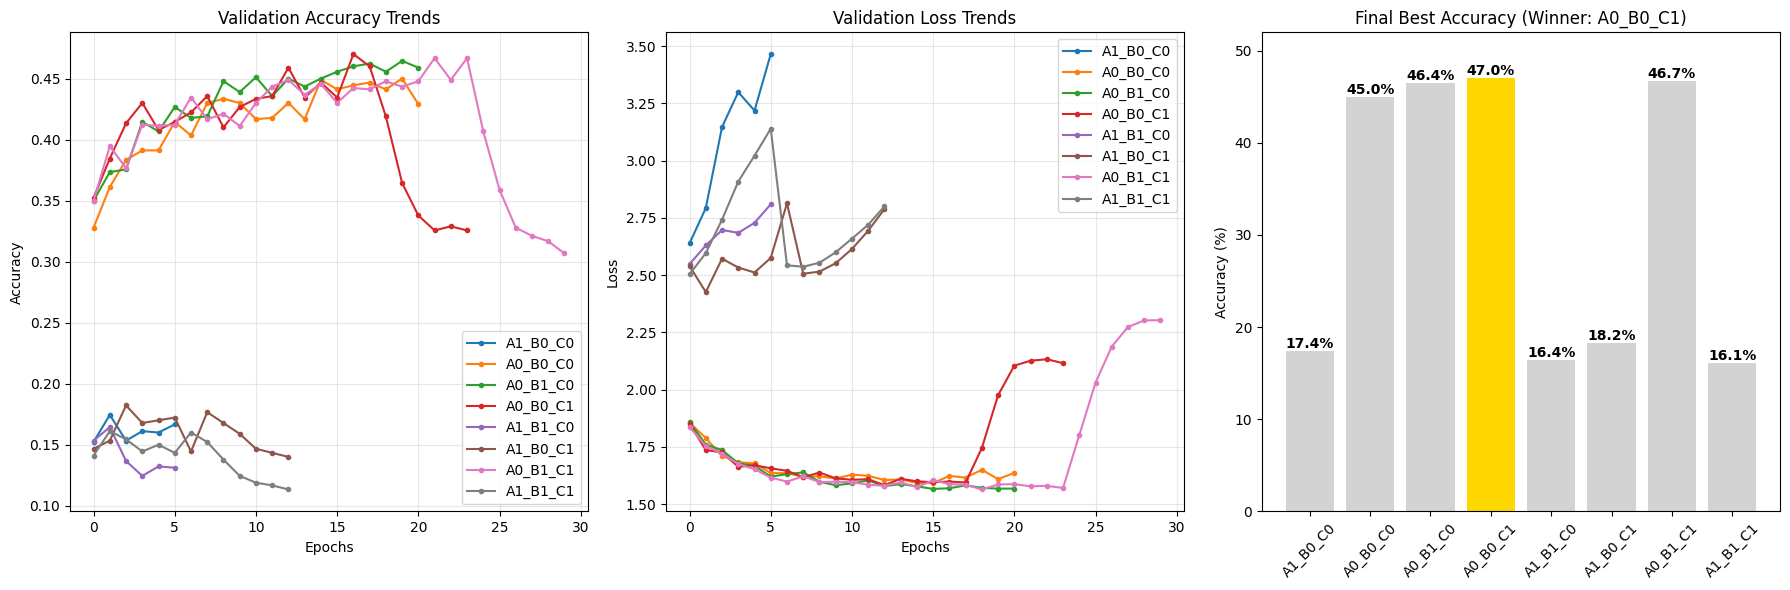

In [34]:
if not final_histories or final_histories is None:
  print("final_histories 없음")
elif not final_results or final_results is None:
  print("final_results 없음")
else:
  print("final_histories, final_results 모두 있음")

plt.figure(figsize=(18, 6))

# [그래프 1] Validation Accuracy 변화 (학습 과정)
plt.subplot(1, 3, 1)
for name, history in final_histories.items():
    plt.plot(history['val_accuracy'], marker='.', label=name)
plt.title('Validation Accuracy Trends')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()

# [그래프 2] Validation Loss 변화 (과적합 확인용)
plt.subplot(1, 3, 2)
for name, history in final_histories.items():
    plt.plot(history['val_loss'], marker='.', label=name)
plt.title('Validation Loss Trends')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# [그래프 3] 최종 결과 비교 (막대 그래프)
plt.subplot(1, 3, 3)
names = list(final_results.keys())
scores = [s * 100 for s in final_results.values()] # %로 변환

# 1등 강조 색상
colors = ['lightgray'] * len(names)
best_idx = np.argmax(scores)
colors[best_idx] = 'gold'

bars = plt.bar(names, scores, color=colors)
plt.title(f'Final Best Accuracy (Winner: {names[best_idx]})')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.ylim(0, max(scores) + 5)

# 막대 위에 점수 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()